# 대화 기록 요약을 추가하는 방법

![](image/langgraph-10.jpeg)

대화 기록을 유지하는 것은 **지속성**의 가장 일반적인 사용 사례 중 하나입니다. 이는 대화를 지속하기 쉽게 만들어주는 장점이 있습니다. 

하지만 대화가 길어질수록 대화 기록이 누적되어 `context window`를 더 많이 차지하게 됩니다. 이는 `LLM` 호출이 더 비싸고 길어지며, 잠재적으로 오류가 발생할 수 있어 바람직하지 않을 수 있습니다. 이를 해결하기 위한 한 가지 방법은 현재까지의 대화 요약본을 생성하고, 이를 최근 `N` 개의 메시지와 함께 사용하는 것입니다. 

이 가이드에서는 이를 구현하는 방법의 예시를 살펴보겠습니다.

다음과 같은 단계가 필요합니다.

- 대화가 너무 긴지 확인 (메시지 수나 메시지 길이로 확인 가능)
- 너무 길다면 요약본 생성 (이를 위한 프롬프트 필요)
- 마지막 `N` 개의 메시지를 제외한 나머지 삭제

이 과정에서 중요한 부분은 오래된 메시지를 삭제(`DeleteMessage`) 하는 것입니다. 


## 환경 설정

In [16]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [1]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


## 긴 대화를 요약하여 대화로 저장

긴 대화에 대하여 요약본을 생성한 뒤, 기존의 대화를 삭제하고 요약본을 대화로 저장합니다.

**조건**

- 대화의 길이가 6개 초과일 경우 요약본을 생성

In [2]:
from typing import Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.graph.message import add_messages

# 메모리 저장소 설정
memory = MemorySaver()


# 메시지 상태와 요약 정보를 포함하는 상태 클래스
class State(MessagesState):
    messages: Annotated[list, add_messages]
    summary: str


# 대화 및 요약을 위한 모델 초기화
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

`ask_llm` 노드는 `messages` 를 llm 에 주입하여 답변을 얻습니다.

만약, **이전의 대화 요약본**이 존재한다면, 이를 시스템 메시지로 추가하여 대화에 포함시킵니다.

하지만, 이전의 대화 요약본이 존재하지 않는다면, 이전의 대화 내용만 사용합니다.

In [3]:
def ask_llm(state: State):
    # 이전 요약 정보 확인
    summary = state.get("summary", "")

    # 이전 요약 정보가 있다면 시스템 메시지로 추가
    if summary:
        # 시스템 메시지 생성
        system_message = f"Summary of conversation earlier: {summary}"
        # 시스템 메시지와 이전 메시지 결합
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        # 이전 메시지만 사용
        messages = state["messages"]

    # 모델 호출
    response = model.invoke(messages)

    # 응답 반환
    return {"messages": [response]}

`should_continue` 노드는 대화의 길이가 6개 초과일 경우 요약 노드로 이동합니다.

그렇지 않다면, 즉각 답변을 반환합니다. (`END` 노드로 이동)

In [4]:
from langgraph.graph import END


# 대화 종료 또는 요약 결정 로직
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    # 메시지 목록 확인
    messages = state["messages"]

    # 메시지 수가 6개 초과라면 요약 노드로 이동
    if len(messages) > 6:
        return "summarize_conversation"
    return END

`summarize_conversation` 노드는 대화 내용을 요약하고, 오래된 메시지를 삭제합니다.

In [5]:
# 대화 내용 요약 및 메시지 정리 로직
def summarize_conversation(state: State):
    # 이전 요약 정보 확인
    summary = state.get("summary", "")

    # 이전 요약 정보가 있다면 요약 메시지 생성
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above in Korean:"
        )
    else:
        # 요약 메시지 생성
        summary_message = "Create a summary of the conversation above in Korean:"

    # 요약 메시지와 이전 메시지 결합
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    # 모델 호출
    response = model.invoke(messages)
    # 오래된 메시지 삭제
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    # 요약 정보 반환
    return {"summary": response.content, "messages": delete_messages}

In [6]:
# 워크플로우 그래프 초기화
workflow = StateGraph(State)

# 대화 및 요약 노드 추가
workflow.add_node("conversation", ask_llm)
workflow.add_node(summarize_conversation)

# 시작점을 대화 노드로 설정
workflow.add_edge(START, "conversation")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "conversation",
    should_continue,
)

# 요약 노드에서 종료 노드로의 엣지 추가
workflow.add_edge("summarize_conversation", END)

# 워크플로우 컴파일 및 메모리 체크포인터 설정
app = workflow.compile(checkpointer=memory)

그래프를 시각화합니다.

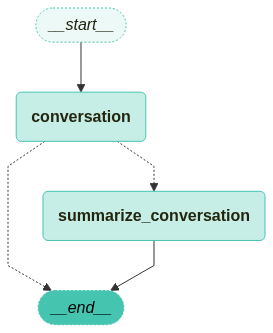

In [7]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 그래프 실행

In [8]:
# 업데이트 정보 출력 함수
def print_update(update):
    # 업데이트 딕셔너리 순회
    for k, v in update.items():
        # 메시지 목록 출력
        for m in v["messages"]:
            m.pretty_print()
        # 요약 정보 존재 시 출력
        if "summary" in v:
            print(v["summary"])

In [9]:
# 메시지 핸들링을 위한 HumanMessage 클래스 임포트
from langchain_core.messages import HumanMessage

# 스레드 ID가 포함된 설정 객체 초기화
config = {"configurable": {"thread_id": "1"}}

# 첫 번째 사용자 메시지 생성 및 출력
input_message = HumanMessage(content="안녕하세요? 반갑습니다. 제 이름은 테디입니다.")
input_message.pretty_print()

# 스트림 모드에서 첫 번째 메시지 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 두 번째 사용자 메시지 생성 및 출력
input_message = HumanMessage(content="제 이름이 뭔지 기억하세요?")
input_message.pretty_print()

# 스트림 모드에서 두 번째 메시지 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 세 번째 사용자 메시지 생성 및 출력
input_message = HumanMessage(content="제 직업은 AI 연구원이에요")
input_message.pretty_print()

# 스트림 모드에서 세 번째 메시지 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

안녕하세요? 반갑습니다. 제 이름은 테디입니다.
================================== Ai Message ==================================

안녕하세요, 테디님! 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

제 이름이 뭔지 기억하세요?
================================== Ai Message ==================================

네, 테디님이라고 하셨습니다! 어떻게 도와드릴까요?
================================ Human Message =================================

제 직업은 AI 연구원이에요
================================== Ai Message ==================================

멋진 직업이네요, 테디님! AI 연구원으로서 어떤 분야에 주로 관심이 있으신가요? 또는 현재 진행 중인 프로젝트가 있으신가요?


지금까지는 요약이 전혀 이루어지지 않은 것을 확인할 수 있습니다 - 이는 목록에 메시지가 6개밖에 없기 때문입니다.

In [10]:
# 상태 구성 값 검색
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='안녕하세요? 반갑습니다. 제 이름은 테디입니다.', additional_kwargs={}, response_metadata={}, id='add063cd-d484-4538-b9a0-a9dd74a941f5'),
  AIMessage(content='안녕하세요, 테디님! 반갑습니다. 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 21, 'total_tokens': 39, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--91f96778-45f6-4361-96b7-e7b7300d56be-0', usage_metadata={'input_tokens': 21, 'output_tokens': 18, 'total_tokens': 39, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='제 이름이 뭔지 기억하세요?', additional_kwargs={}, response_metadata={}, id='0e289086-d

이제 다른 메시지를 보내보겠습니다

In [11]:
# 사용자 입력 메시지 객체 생성
input_message = HumanMessage(
    content="최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다."
)

# 메시지 내용 출력
input_message.pretty_print()

# 스트림 이벤트 실시간 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다.
================================== Ai Message ==================================

LLM(대규모 언어 모델)에 대한 연구는 정말 흥미로운 분야입니다! 최근 몇 년 동안 많은 발전이 있었고, 다양한 논문들이 발표되고 있습니다. 어떤 특정한 주제나 질문이 있으신가요? 아니면 추천할 만한 논문이나 자료를 원하시는 건가요?
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


대화 요약:

사용자는 자신을 테디라고 소개하며, AI 연구원이라고 말했습니다. 테디는 최근 LLM(대규모 언어 모델)에 대해 더 알아보고 있으며, 관련 논문을 읽고 있다고 언급했습니다.


현재 상태를 확인하면 대화의 요약과 함께 마지막 두 개의 메시지를 볼 수 있습니다.

In [12]:
# 상태 구성 값 검색
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다.', additional_kwargs={}, response_metadata={}, id='94d70d04-2bbd-41cc-9e76-c98c8c62022d'),
  AIMessage(content='LLM(대규모 언어 모델)에 대한 연구는 정말 흥미로운 분야입니다! 최근 몇 년 동안 많은 발전이 있었고, 다양한 논문들이 발표되고 있습니다. 어떤 특정한 주제나 질문이 있으신가요? 아니면 추천할 만한 논문이나 자료를 원하시는 건가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 163, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--56832445-7594-47a2-aced-46240ef1aa59-0', usage_metadata={'input_tokens': 163, 'output_tokens': 70, 'total_tokens': 233, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'a

In [13]:
messages = values["messages"]
messages

[HumanMessage(content='최근 LLM 에 대해 좀 더 알아보고 있어요. LLM 에 대한 최근 논문을 읽고 있습니다.', additional_kwargs={}, response_metadata={}, id='94d70d04-2bbd-41cc-9e76-c98c8c62022d'),
 AIMessage(content='LLM(대규모 언어 모델)에 대한 연구는 정말 흥미로운 분야입니다! 최근 몇 년 동안 많은 발전이 있었고, 다양한 논문들이 발표되고 있습니다. 어떤 특정한 주제나 질문이 있으신가요? 아니면 추천할 만한 논문이나 자료를 원하시는 건가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 163, 'total_tokens': 233, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--56832445-7594-47a2-aced-46240ef1aa59-0', usage_metadata={'input_tokens': 163, 'output_tokens': 70, 'total_tokens': 233, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'rea

이제 대화를 재개할 수 있습니다.

마지막 두 개의 메시지만 있더라도 이전 대화 내용에 대해 질문할 수 있습니다 (이전 내용이 요약되어 있기 때문입니다).

In [14]:
# 사용자 메시지 객체 생성
input_message = HumanMessage(content="제 이름이 무엇인지 기억하세요?")

# 메시지 내용 출력
input_message.pretty_print()

# 스트림 이벤트 실시간 처리 및 업데이트
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

제 이름이 무엇인지 기억하세요?
================================== Ai Message ==================================

네, 당신의 이름은 테디입니다!


In [15]:
# 사용자 메시지 객체 생성
input_message = HumanMessage(content="제 직업도 혹시 기억하고 계세요?")

# 메시지 내용 출력
input_message.pretty_print()

# 스트림 이벤트 실시간 처리 및 업데이트 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

제 직업도 혹시 기억하고 계세요?
================================== Ai Message ==================================

네, 당신은 AI 연구원이라고 말씀하셨습니다.
